# Импортируем библиотеки

In [25]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split  

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для кодирования
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Константы:

In [26]:
RANDOM_SEED = 42
DATA_DIR = 'data'

In [27]:
# Подгрузим наши данные из соревнования


df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

1. hotel_address — адрес отеля;
2. review_date — дата, когда рецензент разместил соответствующий отзыв;
3. average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
4. мhotel_name — название отеля;
5. reviewer_nationality — страна рецензента;
6. negative_review — отрицательный отзыв, который рецензент дал отелю;
7. review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
8. positive_review — положительный отзыв, который рецензент дал отелю;
9. review_total_positive_word_counts — общее количество слов в положительном отзыве.
10. reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
11. total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
12. total_number_of_reviews — общее количество действительных отзывов об отеле;
13. tags — теги, которые рецензент дал отелю;
14. days_since_review — количество дней между датой проверки и датой очистки;
15. additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. lat — географическая широта отеля;
17. lng — географическая долгота отеля.

In [28]:
# переводим дату в дейттайм:
# df_train['review_date'] = pd.to_datetime(df_train['review_date'])

# Убираем дубликаты

In [29]:
# найдём дубликаты в тренировочной выборке
dupl_columns = list(df_train.columns)[1:]
mask = df_train.duplicated(subset=dupl_columns)
duplicates = df_train[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

# очистим выборку от дублей
df_train = df_train.drop_duplicates(subset=dupl_columns)
display(df_train.shape)

Число найденных дубликатов: 307


(386496, 17)

# Информация о тренировочном датасете

In [30]:
df_train.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

##### Имеются пропуски в широте и долготе. Подумать об информативности признаков и чем их заполнить.

# Что со строковыми данными?

In [32]:
df_train.describe(include=object)

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386496,386496,386496,386496,386496,386496,386496,386496
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1910,3587,183952,95833,26863,3853,1910


###### Выводы
1. hotel_address	 - всего 1493 уникальных значения, скорее всего головное представительство. Подумать, что можно извлечь из признака в противном случае удалить.
2. hotel_name - ситуация аналогичная. Скорее всего представлены сети
3. reviewer_nationality - подумать какую информацию извлечь из признака
4. negative_review/positive_review	- если разбирать признаки, то они частично перепутаны. в позитивных отзывах самый часто встречающийся отзыв - ничего хорошего а в негативных - ничего плохого. Посмотреть признаки подробнее
5. tags - разобрать детально.
7. days_since_review -пока нет идей


# Числовые признаки

array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>]], dtype=object)

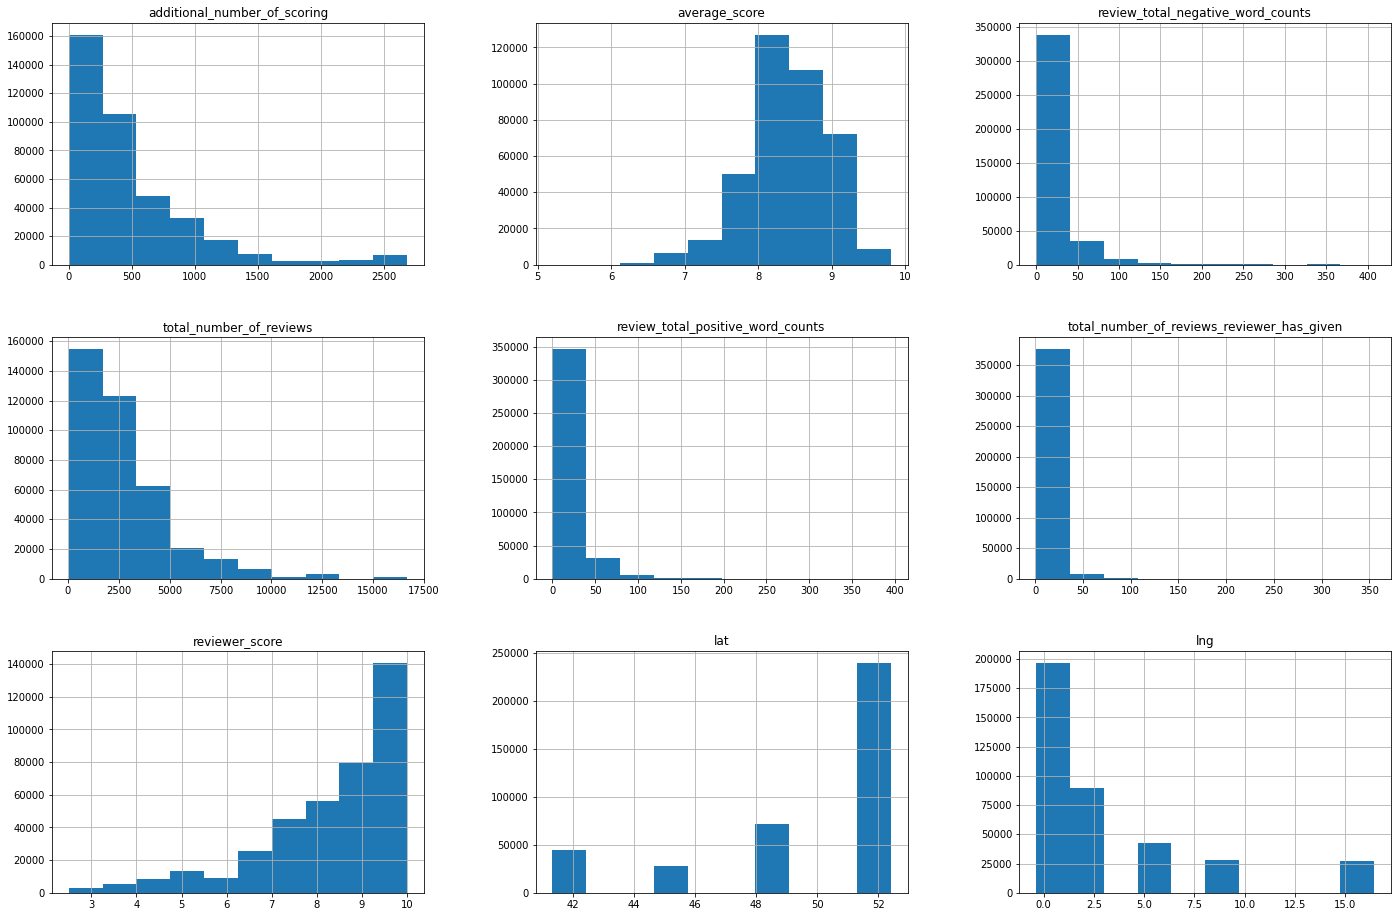

In [33]:
# Построим гистограммы для числовых признаков
df_train.hist(figsize=(24,16))

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет

In [34]:

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\User\AppData\Local\Temp\ipykernel_2776\546920867.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [35]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

# Создадим признак "review_proportinon" - соотношение оценок без комментария к общему количеству оценок, а скоррелированные признаки удалим.

In [36]:
hotels['review_proportion'] = hotels['additional_number_of_scoring'] / \
    hotels['total_number_of_reviews']
drop_cols = ['additional_number_of_scoring', 'total_number_of_reviews']
hotels.drop(drop_cols, axis=1, inplace=True)

In [37]:
# Создадим признак-маркер "bot" для записей оставленных пользователями 
# с большим количеством отзывов 
hotels['bot'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: 1 if x > 70 else 0)

In [38]:
# Посмотрим на формат адреса
display(hotels['hotel_address'][:20])

0                    Via Senigallia 6 20161 Milan Italy
1     Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2           Mallorca 251 Eixample 08008 Barcelona Spain
3     Piazza Della Repubblica 17 Central Station 201...
4     Singel 303 309 Amsterdam City Center 1012 WJ A...
5     Coram Street Camden London WC1N 1HT United Kin...
6     Empire Way Wembley Brent London HA9 8DS United...
7     1 Shortlands Hammersmith and Fulham London W6 ...
8           35 Rue Caumartin 9th arr 75009 Paris France
9     49 Gloucester Place Marble Arch Westminster Bo...
10          Via Giorgio Stephenson 55 20157 Milan Italy
11    Spaarndammerdijk 304 Westerpark 1013 ZX Amster...
12    Damrak 1 5 Amsterdam City Center 1012 LG Amste...
13             Caspe 103 Eixample 08013 Barcelona Spain
14    Via Napo Torriani 24 Central Station 20124 Mil...
15    Oudeschans 75 Amsterdam City Center 1011 KW Am...
16    101 Buckingham Palace Road Westminster Borough...
17    30 Portman Square Westminster Borough Lond

In [39]:
# Определим представленные в выборке страны
country_list = hotels['hotel_address'].apply(lambda x:
    'United Kingdom' if x.split()[-1] == 'Kingdom'
    else x.split()[-1]).unique()
display(country_list)

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

In [40]:
# Посмотрим на представленные в выборке города
display(hotels['hotel_address'].apply(lambda x:
    x.split()[-5] if x.split()[-1] == 'Kingdom'
    else x.split()[-2]).unique())

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [41]:
# Количество городов совпадает с количеством стран. В качестве признака выделим
# страну отеля, так как в будущем планирую создать признак является ли клиент
# гражданином страны отеля.
hotels['country'] = hotels['hotel_address'].apply(lambda x:
    'United Kingdom' if x.split()[-1] == 'Kingdom'
    else x.split()[-1]).astype('category')
# Признак с адрессом удалим. 
hotels.drop('hotel_address', axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   review_date                                 515431 non-null  object  
 1   average_score                               515431 non-null  float64 
 2   hotel_name                                  515431 non-null  object  
 3   reviewer_nationality                        515431 non-null  object  
 4   negative_review                             515431 non-null  object  
 5   review_total_negative_word_counts           515431 non-null  int64   
 6   positive_review                             515431 non-null  object  
 7   review_total_positive_word_counts           515431 non-null  int64   
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64   
 9   tags                                        515431 non-null

In [42]:
# Определим средние координаты по странам (городам) отелей
lat_dict = {}
lng_dict = {}
for country in country_list:
    mask = hotels['country'] == country
    lat = hotels[mask]['lat'].mean()
    lat_dict.update({country: lat})
    lng = hotels[mask]['lng'].mean()
    lng_dict.update({country: lng})

display(lat_dict, lng_dict)
    

{'Italy': 45.4796151241754,
 'Netherlands': 52.36220777032954,
 'Spain': 41.38907941366992,
 'United Kingdom': 51.51073940916046,
 'France': 48.86382513650407,
 'Austria': 48.20336185981613}

{'Italy': 9.191835384840633,
 'Netherlands': 4.885408538404271,
 'Spain': 2.169146783745774,
 'United Kingdom': -0.13896019919939656,
 'France': 2.326798927688699,
 'Austria': 16.36723348992923}

In [43]:
# Заполняем пропуски координат
hotels['lat'] = hotels[['country', 'lat']].apply(lambda x:
    lat_dict[x.country] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['country', 'lng']].apply(lambda x:
    lng_dict[x.country] if np.isnan(x.lng) else x.lng, axis=1)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   review_date                                 515431 non-null  object  
 1   average_score                               515431 non-null  float64 
 2   hotel_name                                  515431 non-null  object  
 3   reviewer_nationality                        515431 non-null  object  
 4   negative_review                             515431 non-null  object  
 5   review_total_negative_word_counts           515431 non-null  int64   
 6   positive_review                             515431 non-null  object  
 7   review_total_positive_word_counts           515431 non-null  int64   
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64   
 9   tags                                        515431 non-null

In [44]:
# Меняем тип данных для признака "даты отзыва"
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Создаем признак "месяц отзыва"
#hotels['review_month'] = pd.to_datetime(
#    hotels['review_date']).dt.month.astype('category')
# Создаем признак "День недели отзыва"
hotels['review_day'] = pd.to_datetime(
    hotels['review_date']).dt.day_of_week.astype('category')

# Меняем тип признака "кол-во дней после отзыва" на числовой
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x:
                            int(x.replace(' days', '').replace(' day', '')))

hotels.drop('review_date', axis=1, inplace=True)

Есть предположение, что отзыв зависит от таких факторов:

1. является ли постоялец гражданином страны члена ЕС или мусульманской.
2. как хорошо постоялец владеет английским языком.
3. является ли постоялец гражданином страны, в которой расположен отель.

In [45]:
# Категоризируем клиентов по национальности. Чтобы не плодить признаки выделим
# максимальное количество которое можно закодировать 6-ю битами (столбцами)
country_list = list(hotels['reviewer_nationality'].value_counts()[:62].index)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: 
                                            x if x in country_list else 'other')
display(hotels['reviewer_nationality'].value_counts())

 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
other                          14471
                               ...  
 Taiwan                          923
 Pakistan                        916
 Slovakia                        903
 Jersey                          862
 Slovenia                        796
Name: reviewer_nationality, Length: 63, dtype: int64

In [46]:
# создадим списки стран где английский язык не является государственным 
# в зависимости от уровня владения по стране.
# (таблицы создал на основе EF English Proficiency Index)
import re

file = open('data' + '/very_low_proficiency.txt', "r") #Открываем файл
very_low_proficiency = []
line = file.readline()
while line:
    # r'[^\w\s]+|[\d]+' - регулярное выражения для очистки строки от "мусора" 
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    very_low_proficiency.append(country) # вставляем в список название страны
    line = file.readline()

file = open('data' + '/low_proficiency.txt', "r") 
low_proficiency = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    low_proficiency.append(country)
    line = file.readline()

file = open('data' + '/moderate.txt', "r")
moderate = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    moderate.append(country)
    line = file.readline()
    
file = open('data' + '/high.txt', "r")
high = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    high.append(country)
    line = file.readline()
    
file = open('data' + '/very_high.txt', "r")
very_high = []
line = file.readline()
while line:
    country = re.sub(r'[^\w\s]+|[\d]+', r'', line).replace(' \n', '')[1:]
    very_high.append(country)
    line = file.readline()

# Удалим пробелы внчале и в конце строки страны постояльца.
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x.strip()).astype('category')
    
hotels['eng_proficiency'] = hotels['reviewer_nationality'].apply(lambda x:
    1 if x in very_low_proficiency 
    else 2 if x in low_proficiency
    else 3 if x in moderate or x == 'other'
    else 4 if x in high
    else 5 if x in very_high
    else 6 # группа где английский - государственный язык
    ).astype('category')

hotels[hotels['eng_proficiency'] == 6]['reviewer_nationality'].unique()

['United Kingdom', 'Belgium', 'Sweden', 'United States of America', 'Netherlands', ..., 'Luxembourg', 'Indonesia', 'Croatia', 'Iran', 'Nigeria']
Length: 62
Categories (63, object): ['Australia', 'Austria', 'Bahrain', 'Belgium', ..., 'United Arab Emirates', 'United Kingdom', 'United States of America', 'other']

In [48]:
# Создадим признак указывающий, "местный" ли постоялец
hotels['is_local'] = hotels[['country', 'reviewer_nationality']].apply(
    lambda x: 1 if x['country'] == x['reviewer_nationality'] else 0, axis=1)

hotels.drop('country', axis=1, inplace=True)

In [ ]:
# Выявим самые популярные тэги признака "tags"
from collections import Counter

tags_list = hotels['tags'].tolist()
tags = []
for i in tags_list:
    symbols = ["[", "]", "'"]
    for j in symbols:
        i = i.replace(j, '')
    tags += i.split(',')
# Выведем топ30 тэгов
pop_tag = Counter(tags).most_common(30)
display(pop_tag)

[(' Leisure trip ', 416432),
 ('  Submitted from a mobile device ', 307470),
 ('  Couple ', 246324),
 ('  Stayed 1 night ', 193568),
 ('  Stayed 2 nights ', 133850),
 ('  Solo traveler ', 104191),
 ('  Stayed 3 nights ', 95761),
 (' Business trip ', 82693),
 ('  Group ', 63761),
 ('  Family with young children ', 58764),
 ('  Stayed 4 nights ', 47777),
 ('  Double Room ', 35207),
 ('  Standard Double Room ', 32247),
 ('  Superior Double Room ', 31361),
 ('  Family with older children ', 25403),
 ('  Deluxe Double Room ', 24812),
 ('  Double or Twin Room ', 22393),
 ('  Stayed 5 nights ', 20826),
 ('  Standard Double or Twin Room ', 17479),
 ('  Classic Double Room ', 16877),
 ('  Superior Double or Twin Room ', 13570),
 ('  2 rooms ', 12384),
 ('  Stayed 6 nights ', 9765),
 ('  Standard Twin Room ', 9745),
 ('  Single Room ', 9668),
 ('  Twin Room ', 8320),
 ('  Stayed 7 nights ', 7391),
 ('  Executive Double Room ', 6425),
 ('  Classic Double or Twin Room ', 6100),
 ('  Superior Twin 

Из списка популярных тегов можно вывести бинарные и категориальные признаки:

1. Тип путешествия "leisure_trip"(Leisure/Business Trip) 416432 + 82693 = 499125
2. Источник отзыва "mobile_submit" (с мобильного девайса или нет)
3. Количество ночей "nights_count"(Stayed n nights)
4. Один, пара или группа путешественников "people_count"
5. Постоялец с маленьким ребёнком "children"
6. Создадим эти признаки.

In [ ]:
hotels['leisure_trip'] = hotels['tags'].apply(lambda x:
    1 if 'Leisure trip' in x else 0) 
hotels['mobile_submit'] = hotels['tags'].apply(lambda x:
    1 if 'Submitted from a mobile device' in x else 0) 
hotels['nights_count'] = hotels['tags'].apply(lambda x: 
    1 if 'Stayed 1 night' in x else
    2 if 'Stayed 2 nights' in x else
    3 if 'Stayed 3 nights' in x else
    4) 
hotels['people_count'] = hotels['tags'].apply(lambda x: 
    1 if 'Solo traveler' in x else
    2 if 'Couple' in x else
    0)
hotels['children'] = hotels['tags'].apply(lambda x: 
    1 if 'Family with young children' in x else 0)
hotels['people_count'].value_counts()

hotels.drop('tags', axis=1, inplace=True)

In [ ]:
#кодируем признаки
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
rev_nations_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, rev_nations_bin], axis=1)

hotels.drop('reviewer_nationality', axis=1, inplace=True)

oh_cols = ['nights_count', 'people_count', 'review_day']# указываем столбцы для кодирования
encoder = ce.OneHotEncoder(cols=oh_cols) 
country_oh = encoder.fit_transform(
    hotels[['nights_count', 'people_count', 'review_day']])
hotels = pd.concat([hotels, country_oh], axis=1)

hotels.drop(oh_cols, axis=1, inplace=True)

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515431 non-null  float64 
 1   hotel_name                                  515431 non-null  object  
 2   negative_review                             515431 non-null  object  
 3   review_total_negative_word_counts           515431 non-null  int64   
 4   positive_review                             515431 non-null  object  
 5   review_total_positive_word_counts           515431 non-null  int64   
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64   
 7   days_since_review                           515431 non-null  int64   
 8   lat                                         515431 non-null  float64 
 9   lng                                         515431 non-null

Text(0.5, 1.0, 'Корреляция Пирсона')

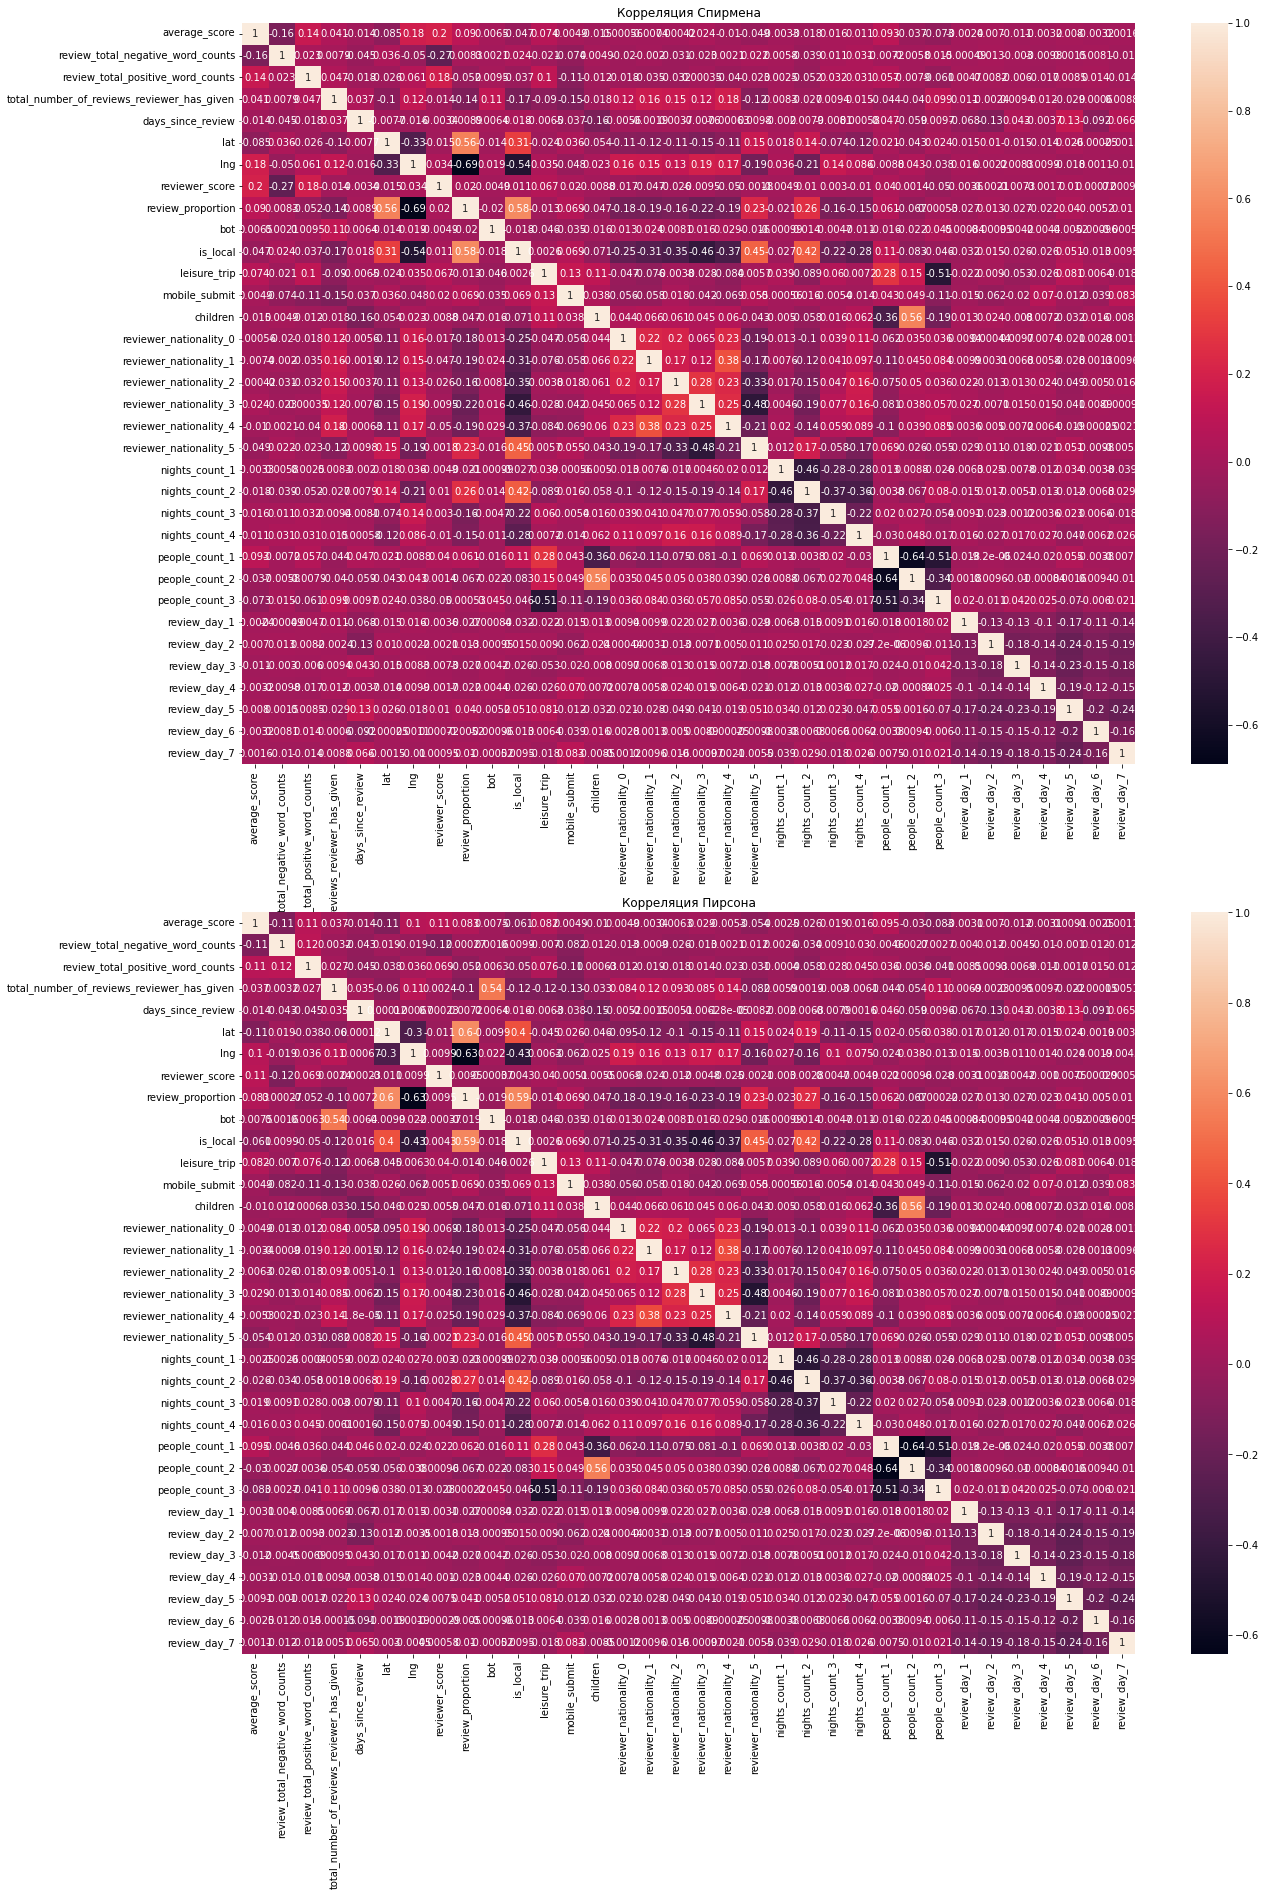

In [ ]:
# Выведем корреляцию по методу Писрона и Спирмена для признаков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (20,30))

spearman_data = hotels.drop(['sample'], axis=1).corr(method='spearman')

    
sns.heatmap(spearman_data, annot=True, ax=axes[0])

pearson_data = hotels.drop(['sample'], axis=1).corr(method='pearson')

    
sns.heatmap(pearson_data, annot=True, ax=axes[1])

axes[0].set_title('Корреляция Спирмена')
axes[1].set_title('Корреляция Пирсона')

In [ ]:
hotels.corr()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,reviewer_score,review_proportion,bot
average_score,1.000000,-0.112347,0.106723,0.036529,-0.013961,-0.108393,0.099852,-0.000659,0.113686,0.083163,0.007529
review_total_negative_word_counts,-0.112347,1.000000,0.119664,0.003234,-0.043261,0.019127,-0.019459,-0.000021,-0.120581,0.000271,0.001624
review_total_positive_word_counts,0.106723,0.119664,1.000000,0.026534,-0.044994,-0.037711,0.035597,0.000065,0.069021,-0.052262,0.006339
total_number_of_reviews_reviewer_has_given,0.036529,0.003234,0.026534,1.000000,0.035088,-0.059768,0.112030,0.001725,0.002396,-0.103571,0.536324
days_since_review,-0.013961,-0.043261,-0.044994,0.035088,1.000000,0.000123,0.000671,-0.000548,0.000225,0.007167,0.006412
lat,-0.108393,0.019127,-0.037711,-0.059768,0.000123,1.000000,-0.302623,0.000578,-0.011064,0.604743,-0.009876
lng,0.099852,-0.019459,0.035597,0.112030,0.000671,-0.302623,1.000000,-0.000370,0.009881,-0.630476,0.022073
sample,-0.000659,-0.000021,0.000065,0.001725,-0.000548,0.000578,-0.000370,1.000000,0.931821,0.001501,0.000196
reviewer_score,0.113686,-0.120581,0.069021,0.002396,0.000225,-0.011064,0.009881,0.931821,1.000000,0.009481,-0.000370
review_proportion,0.083163,0.000271,-0.052262,-0.103571,0.007167,0.604743,-0.630476,0.001501,0.009481,1.000000,-0.018984


In [ ]:
# Удаляем текстовые признаки, признаки с высокой корреляцией и 
# малозначительные признаки 
object_cols = [s for s in hotels.columns if hotels[s].dtypes == 'object']

trash_cols = ['lat','lng', 'is_local', 'reviewer_nationality_0',
              'reviewer_nationality_1', 'reviewer_nationality_2',
              'nights_count_4', 'bot', 'children']
drop_cols = object_cols + trash_cols
hotels_ml = hotels.drop(drop_cols, axis = 1)
hotels_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515431 non-null  float64 
 1   review_total_negative_word_counts           515431 non-null  int64   
 2   review_total_positive_word_counts           515431 non-null  int64   
 3   total_number_of_reviews_reviewer_has_given  515431 non-null  int64   
 4   days_since_review                           515431 non-null  int64   
 5   sample                                      515431 non-null  int64   
 6   reviewer_score                              515431 non-null  float64 
 7   review_proportion                           515431 non-null  float64 
 8   eng_proficiency                             515431 non-null  category
 9   leisure_trip                                515431 non-null

In [ ]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()

# кодируем исходный датасет
# выделяем все признаки кроме целевого
hotels_ml_mm = hotels_ml.drop(['reviewer_score'], axis=1)
col_names = list(hotels_ml_mm.columns)
hotels_ml_mm = mm_scaler.fit_transform(hotels_ml_mm)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_ml_mm = pd.DataFrame(hotels_ml_mm, columns=col_names)
hotels_ml_mm['reviewer_score'] = hotels_ml['reviewer_score']
hotels_ml_mm.describe()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,review_proportion,eng_proficiency,leisure_trip,mobile_submit,...,people_count_2,people_count_3,review_day_1,review_day_2,review_day_3,review_day_4,review_day_5,review_day_6,review_day_7,reviewer_score
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,515431.000000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,0.695137,0.045441,0.045006,0.017416,0.485487,0.74985,0.421298,0.971924,0.810075,0.596530,...,0.300384,0.210457,0.086725,0.157340,0.144444,0.100508,0.234526,0.113610,0.162846,6.296715
std,0.119138,0.072772,0.055198,0.031183,0.286185,0.43310,0.201190,0.165189,0.392242,0.490594,...,0.458425,0.407634,0.281433,0.364122,0.351540,0.300677,0.423703,0.317337,0.369226,3.902967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.630435,0.004902,0.012658,0.000000,0.239726,0.00000,0.235332,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.695652,0.022059,0.027848,0.005650,0.483562,1.00000,0.414221,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.900000
75%,0.782609,0.056373,0.055696,0.019774,0.721918,1.00000,0.580796,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [ ]:
# Теперь выделим тестовую часть
train_data = hotels_ml.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_ml.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (386496, 26), (386496, 25), (309196, 25), (77300, 25))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Добавляем логгирование нашего эксперимента

# Функция для создания лог-файла и записи в него информации
def get_logger(path, file):
  """[Создает лог-файл для логирования в него]
  Аргументы:
      path {string} -- путь к директории
      file {string} -- имя файла
   Возвращает:
      [obj] -- [логер]
  """
  # проверяем, существует ли файл
  log_file = os.path.join(path, file)
 
  #если  файла нет, создаем его
  if not os.path.isfile(log_file):
    open(log_file, "w+").close()
  
  # зададим формат логирования
  file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"
  
  logger = logging.getLogger()

  # создадим хэнлдер для записи лога в файл
  handler = logging.FileHandler(log_file)
  
  # установим уровень логирования
  handler.setLevel(logging.INFO)
  
  # создадим формат логирования, используя file_logging_format
  formatter = logging.Formatter(file_logging_format)
  handler.setFormatter(formatter)
  
  # добавим хэндлер лог-файлу
  logger.addHandler(handler)
  return logger

logger = get_logger(path="data", file="data.logs")

logger.setLevel(10) 



In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   24.4s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
print('MAPE:', mape)
logger.info(f'MAPE: {mape}')
print('MAE:', mae)
logger.info(f'MAE: {mae}')

MAPE: 0.13558355308478928
MAE: 0.937383784513029


<AxesSubplot: >

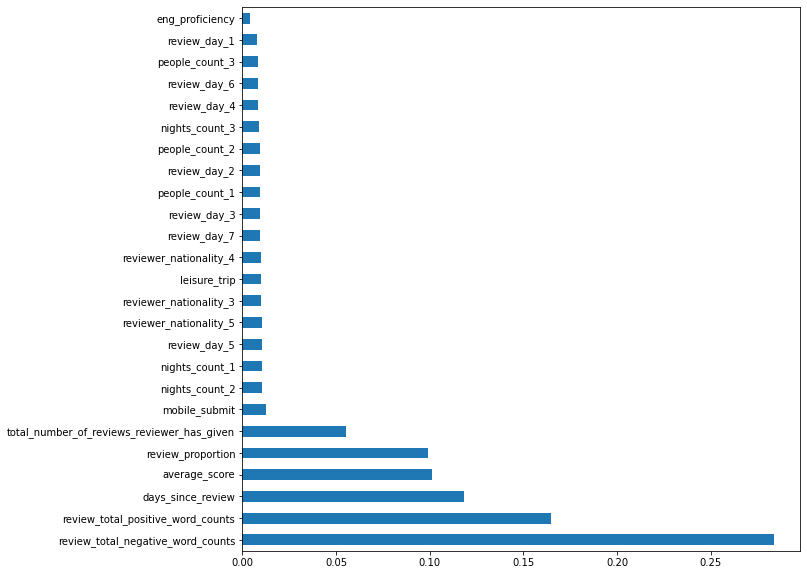

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(68).plot(kind='barh')

In [ ]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,review_proportion,eng_proficiency,leisure_trip,mobile_submit,...,people_count_1,people_count_2,people_count_3,review_day_1,review_day_2,review_day_3,review_day_4,review_day_5,review_day_6,review_day_7
69608,8.6,0,52,1,460,0.0,0.065375,6,1,0,...,1,0,0,0,0,0,1,0,0,0
39964,9.3,10,9,6,318,0.0,0.245796,6,1,1,...,1,0,0,0,1,0,0,0,0,0
24777,7.9,7,4,17,14,0.0,0.090656,6,1,0,...,0,1,0,0,0,1,0,0,0,0
99274,7.8,87,29,3,67,0.0,0.252183,6,1,1,...,0,1,0,0,0,0,0,0,0,1
24052,7.8,53,12,3,333,0.0,0.102340,6,1,1,...,1,0,0,0,0,0,0,0,0,1
128843,9.2,0,17,15,724,0.0,0.137405,6,1,0,...,1,0,0,0,1,0,0,0,0,0
70566,7.8,8,9,1,728,0.0,0.252183,6,1,1,...,1,0,0,0,0,1,0,0,0,0
106064,8.4,0,4,9,678,0.0,0.255956,6,1,0,...,1,0,0,1,0,0,0,0,0,0
44006,8.8,47,59,1,72,0.0,0.128000,6,1,0,...,0,0,1,0,0,0,0,1,0,0
11038,8.5,56,0,7,246,0.0,0.289095,6,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.5s finished


In [ ]:
predict_submission

array([8.743, 7.417, 7.983, ..., 7.836, 9.731, 7.417])

In [ ]:
list(sample_submission)

['reviewer_score', 'id']

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.743,488440
1,7.417,274649
2,7.983,374688
3,9.508,404352
4,9.624,451596
5,8.417,302161
6,8.526,317079
7,7.501,13963
8,8.581,159785
9,7.811,195089
